# Clustering

### Motivation
Membrane proteins are very mysterious: their shape and folding is rigidly constrained by the geometry of the lipid bilayer they are inserted in, and yet they carry out 50% of the functions in any type of cell. Slight structural changes, coupled with just the right changes in the biochemistry of the amino acid sequence, can give rise to extremely diverse behaviors. This is for sure the case with the very large group of [G protein-coupled receptors][https://en.wikipedia.org/wiki/G_protein-coupled_receptor], which couple with Guanine nucleotide-binding (G) proteins and have a distinct structural trademark: they all have exactly 7 transmembrane helices. Among the many protein families in this group, [Rhodopsin-like receptors][https://en.wikipedia.org/wiki/Rhodopsin-like_receptors] also share a similar active site. Their functions remain nonetheless very diverse: the targets of these receptors can be neuropeptides, neurotransmitters, and even light (like the Rhodopsin itself).
The function and evolution of many of these proteins remain not well ascertained: in this labwork we will try to **analyze the proteins' structural differences and see whether we can infer something about their classification and their evolutionary history**.

### Data
Protein structures can be aligned (i.e. carefully and somehow flexibly superposed) by means of the many available structure alignment algorithms. Moreover, in order to appreciate the slight structural differences in this group, we will need a good measure for calculating the similarity between the aligned structures. We will work with data taken from [EncoMPASS - the Encyclopedia of Membrane Proteins Analyzed by Structure and Symmetry][https://encompass.ninds.nih.gov/]. The metric we will use is the TM-score, and the TM-score of a target protein aligned to a template structure is defined as

$\mathrm{TM-score} = \max\left[\frac{1}{L_{\mathrm{target}}}\sum^{L_{\mathrm{common}}}_i\frac{1}{1 + \left(\frac{d_i}{d_0(L_{\mathrm{target}})}\right)^2}\right]$

Where $L_{\mathrm{target}}$ is the length of the sequence of the target protein, and $L_{\mathrm{common}}$ is the number of amino acids the two proteins have in common. A TM-score of 1 indicates a perfect alignment, whereas a TM-score of 0 a complete misalignment. A TM-score of >0.5 is a good indicator that the two structures are related to each other.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

## Learn about the data

The file *rhodopsins.txt* contains all the TM-scores associated with any pair of rhodopsin-like proteins whose structure has been experimentally determined.
The first technical problem we encounter is that the TM-score is not a distance: can you identify all the reasons why it isn't?

Among the reasons why the TM-score cannot be used as a distance, there is one which is even more fundamental than the others: state it and add here the code for respecting this condition.

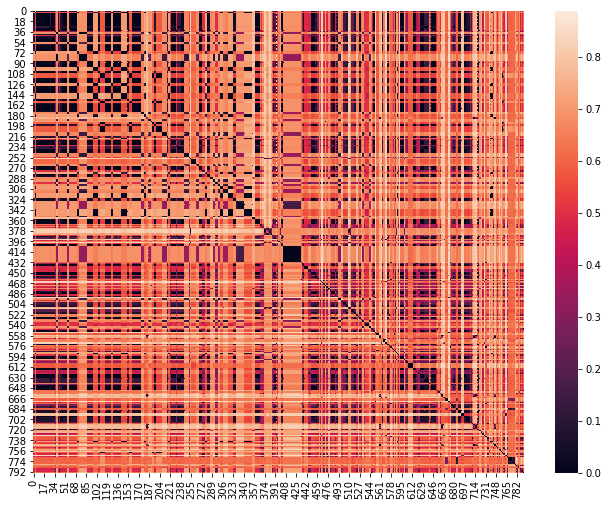

In [3]:
# Reads the file
dist = {}
keys = set()
with open('rhodopsinlike.txt') as f:
    for line in f:
        fields = line.split()
        dist[(fields[0]+'_'+fields[1], fields[2]+'_'+fields[3])] = float(fields[8])
        keys.add(fields[0]+'_'+fields[1])

# Creates an ordered list of labels
lkeys = sorted(list(keys))

# Creates the TM-score matrix
X = np.ones((len(lkeys), len(lkeys)))
for i1, k1 in enumerate(lkeys):
    for q, k2 in enumerate(lkeys[i1+1:]):
        i2 = q + i1 + 1
        X[i1, i2] = dist[(k1, k2)]
        X[i2, i1] = dist[(k1, k2)]

'''Add your code here'''
X = 1 - X
'''End of your code'''

# Plot the "distance" matrix you have obtained
import seaborn as sns

plt.figure(figsize=(11,8.5))
sns.heatmap(X)
plt.show()

## Dimensionality reduction

A large set of pairwise distances generally lies in a high-dimensional space <sup>1</sup>. In order to visualize it, we will need as usual to reduce the dimensionality, this time with an algorithm that can accept distances instead of coordinates: [Multidimensional scaling][https://en.wikipedia.org/wiki/Multidimensional_scaling].
Remember: all the consideration we will make will be exact in the original, N-dimensional space! In 2D, they hopefully will not be too off, but they will for sure be an approximation.

<sup>1</sup> *As an example, think about the simple case where you have three points, each of which is distant 1 from all the others. The only possible arrangement is when the points form an equilateral triangle. If now you add a fourth point which has to respect the same condition, 2 dimensions will not be enough! The only possible arrangement in 3 dimensions is the regular tetrahedron.*

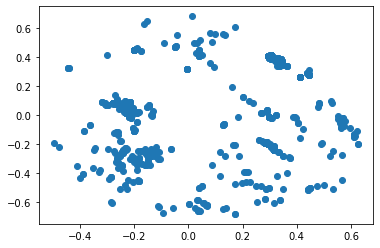

In [4]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed', metric=True)
X_2D = embedding.fit_transform(X)
plt.scatter(X_2D[:,0], X_2D[:,1])

## Clustering with K-means

Kmeans is a classical, workhorse clustering algorithm, and a common place to start. It assumes there are K centers and, starting from random guesses, algorithmically improves its guess about where the centers must be.

<div class="alert alert-block alert-danger">
Using the KMeans function of sklearn, propose a first clustering in 3 clusters with 25 runs

To help you, you must use the parameters:
    
* `n_clusters`: The number of clusters to form as well as the number of centroids to generate.
* `n_init`: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
* `random_state`: Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    
Using the `cluster_centers` attribute, print the coodinate of each cluster centers.
</div>

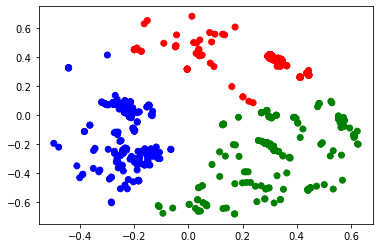

In [5]:
from sklearn.cluster import KMeans
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'black', '0.5', 'pink', 'cyan', 'magenta', 'beige', 'lightblue', 'lightgreen']

''' TO DO '''
struct_km = KMeans(n_clusters=3,n_init=25,random_state=127).fit(X_2D)

#struct_km.cluster_centers_
color_labels = [colors[i] for i in struct_km.labels_]
plt.scatter(X_2D[:,0], X_2D[:,1], c=color_labels)

We now calculate the average of the points of each cluster to obtain the centroid found by K-means.

In [6]:
nlabels = len(set(struct_km.labels_))
norms = [sum(1*(struct_km.labels_ == i)) for i in range(nlabels)]
coords = [np.zeros((norms[i], 2)) for i in range(nlabels)]
indexes = [0]*nlabels
for i in range(X_2D.shape[0]):
    j = struct_km.labels_[i]
    coords[j][indexes[j]] = X_2D[i]
    indexes[j] += 1
centroids = [np.sum(coords[i], axis=0)/norms[i] for i in range(nlabels)]
print(centroids)

[array([0.20109084, 0.37781685]), array([-0.24265117, -0.04078464]), array([ 0.30355648, -0.27235502])]


<div class="alert alert-block alert-danger">
Do we get the same value as when looking at the cluster_centers_ attribute ?
</div>

In [7]:
struct_km.cluster_centers_

array([[ 0.20109084,  0.37781685],
       [-0.24265117, -0.04078464],
       [ 0.30355648, -0.27235502]])

Plot the dataset with the cluster attributes

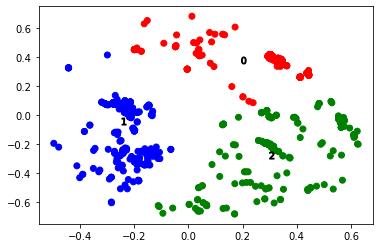

In [8]:
color_labels = [colors[i] for i in struct_km.labels_]
plt.scatter(X_2D[:,0], X_2D[:,1], c=color_labels)
for i, c in enumerate(centroids):
    plt.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

### Plot the distortions of K-means

<div class="alert alert-block alert-danger">
You can easily run K-Means with several run for a range of clusters using a for loop and collecting the distortions into a list.
    
You can collect the distortions using the `inertia_`attribute. `inertia_`is the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    
Then plots the distortions of K-means.
</div>

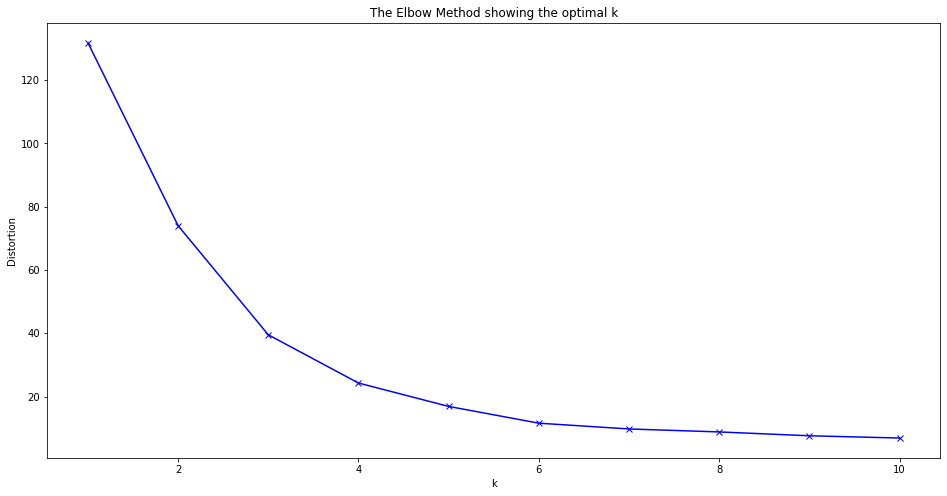

In [9]:
distortions = []
for k in range(1,11):
    km = KMeans(n_clusters=k, init='random', n_init=25, random_state=123).fit(X_2D)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(range(1,11), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<div class="alert alert-block alert-danger">
What is the best number of clusters when using the Elbow method?
</div>

### Silhouette Plots
Silhouette plots give rich information on the quality of a clustering


In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    # axes 
    ax2.scatter(X_2D[:, 0], X_2D[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_2D[:, 0]
    ys = X_2D[:, 1]


    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 3, the average silhouette_score is 0.5698231568166033.


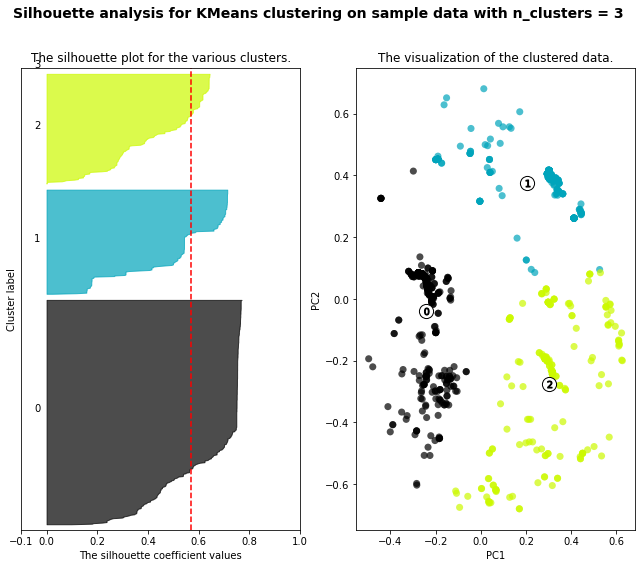

In [11]:
fitted_km = KMeans(n_clusters=3,n_init=25,random_state=123).fit(X_2D)
cluster_labels = fitted_km.labels_

silplot(X_2D, cluster_labels, fitted_km)

### Silhouette Score

<div class="alert alert-block alert-danger">
Now plot the score of the silhouette as the number of clusters varies.
</div>

Optimized at 7 clusters


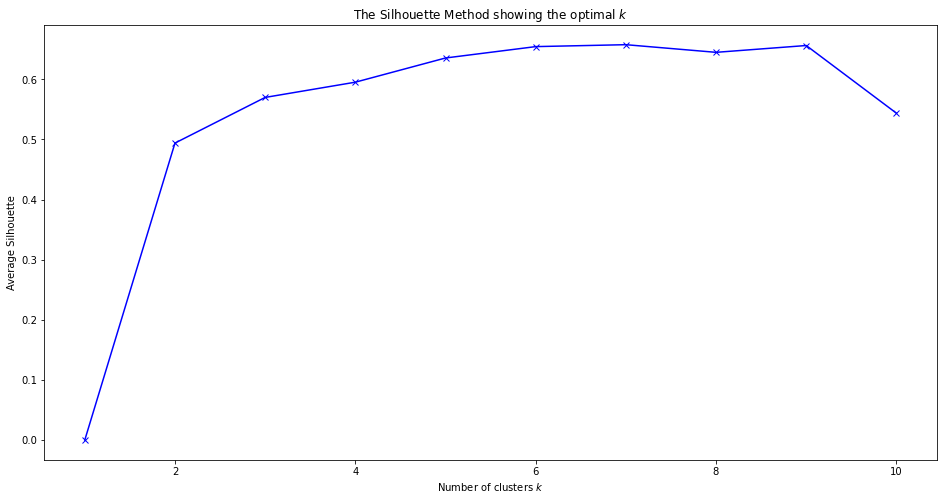

In [12]:
from sklearn.metrics import silhouette_score

scores = [0]  # silhouette score for 1 cluster
for i in range(2,11):
    km = KMeans(n_clusters=i, init='random', n_init=25, random_state=109).fit(X_2D)
    scores.append(silhouette_score(X_2D, km.labels_))

print("Optimized at", max(range(len(scores)), key=scores.__getitem__)+1, "clusters")

plt.figure(figsize=(16,8))
plt.plot(range(1,11), scores, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Silhouette Method showing the optimal $k$')
plt.show()

<div class="alert alert-block alert-danger">
What is the best number of clusters when using the Silhouet method?

Is it the same as with the Elbow method?
    
Cluster the dataset with the best number of clusters and try to explain each cluster.
</div>

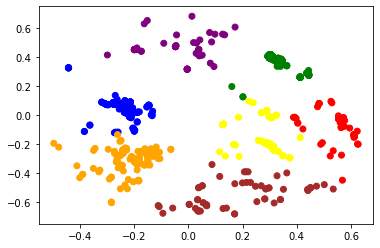

In [13]:
''' TO DO '''
struct_km = KMeans(n_clusters=7,n_init=25,random_state=123).fit(X_2D)
color_labels = [colors[i] for i in struct_km.labels_]
plt.scatter(X_2D[:,0], X_2D[:,1], c=color_labels)

#### Gap Statistic

The gap statistic is a method for estimating the number of clusters in a dataset. The techniques uses the output of any clustering algorithm, comparing the change in within-cluster dispersion with that expected under an appropriate reference null distribution. The original paper is [here](https://web.stanford.edu/~hastie/Papers/gap.pdf).

* Githup page: [https://github.com/milesgranger/gap_statistic]
* [K-Means Clustering and the Gap-Statistics](https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29)

In [14]:
# need to install library 'gap-stat'
#!pip install gap-stat

In [15]:
from gap_statistic import OptimalK

gs_obj = OptimalK()

n_clusters = gs_obj(X_2D,                                # The dataset
                    n_refs=100,                          # Number of runs
                    cluster_array=np.arange(1, 15))      # Range of clusterization
print('Optimal clusters: ', n_clusters)

Optimal clusters:  7


In [16]:
gs_obj.gap_df.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,0.442392,73.377221,4.373693,0.021389,73.874077,0.061536,74.698616
1,2.0,0.459530,43.524601,9.841747,0.078675,44.845997,-0.063059,43.760074
2,3.0,0.550548,32.889775,2.163454,0.027959,33.125247,-0.156364,33.180660
3,4.0,0.759658,27.666538,2.905408,0.052745,27.957423,-0.119356,27.890641
4,5.0,0.926876,25.799815,2.215502,0.047863,26.023918,0.188474,25.960315


The columns of the dataframe are:

* n_clusters - The number of clusters for which the statistics in this row were calculated.
* gap_value - The Gap value for this n.
* gap* - The Gap* value for this n.
* ref_dispersion_std - The standard deviation of the reference distributions for this n.
* sk - The standard error of the Gap statistic for this n.
* sk* - The standard error of the Gap* statistic for this n.
* diff - The diff value for this n (see the methodology section for details).
* diff* - The diff* value for this n (corresponding to the diff value for Gap*).

Additionally, the relation between the above measures and the number of clusters can be plotted by calling the OptimalK.plot_results() method (meant to be used inside a Jupyter Notebook or a similar IPython-based notebook), which prints four plots:

* A plot of the Gap value versus n, the number of clusters.
* A plot of diff versus n.
* A plot of the Gap* value versus n, the number of clusters.
* A plot of the diff* value versus n.

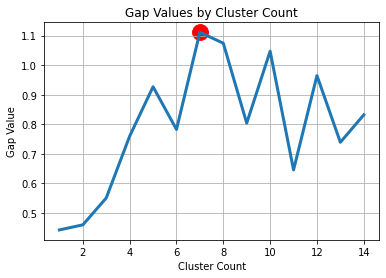

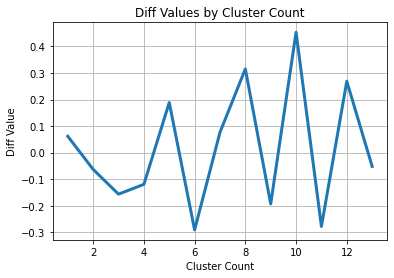

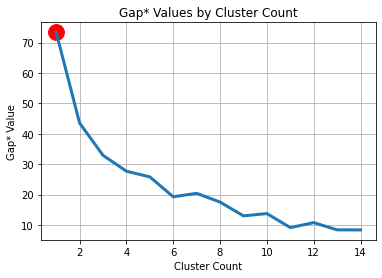

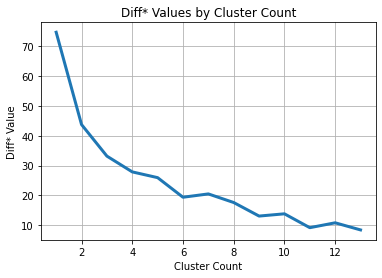

In [17]:
gs_obj.plot_results()

<div class="alert alert-block alert-danger">    
Cluster the dataset with the best number of clusters givent by gap-stat and try to explain each cluster.
</div>

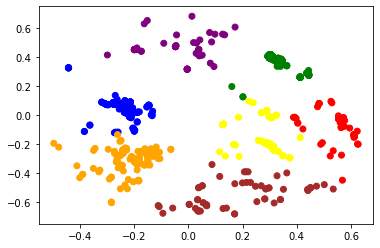

In [18]:
''' TO DO '''
struct_km = KMeans(n_clusters=7,n_init=25,random_state=123).fit(X_2D)
color_labels = [colors[i] for i in struct_km.labels_]
plt.scatter(X_2D[:,0], X_2D[:,1], c=color_labels)

<div class="alert alert-block alert-danger">    
Try to explain each cluster
</div>

## Hierarchical clustering

K-means is a very 'hard' clustering: points belong to exactly one cluster, no matter what. A hierarchical clustering creates a nesting of clusters as existing clusters are merged or split.

Dendograms (literally: branch graphs) can show the pattern of splits/merges. Unfortunately dendograms are not implemented in sklearn. We have to use the scipy library.

In [19]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

The following code shows different dendograms build with different algorithms:

1. Min (or single linkage) algorithm with euclidian distance: the distance of the new cluster, is the min.
1. Max (or complete linkage) algorithm with euclidian distance: : the distance of the new cluster, is the max.
1. Ward algorithm with euclidean distance: the distance of the new cluster, is the average of the sum of the square of the distance.

![three linkage type](https://www.researchgate.net/profile/Pamela-Guevara/publication/281014334/figure/fig57/AS:418517879934980@1476793847581/The-three-linkage-types-of-hierarchical-clustering-single-link-complete-link-and.png)

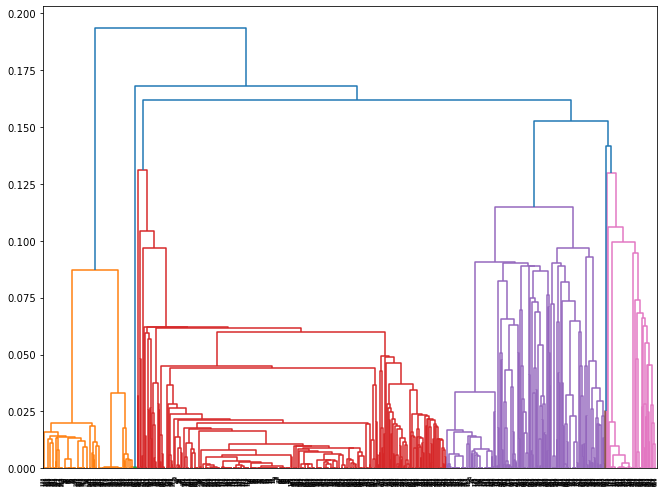

In [20]:
# Min (or single linkage) algorithm with euclidian distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(X_2D, metric="minkowski", p=2) # Euclidian
ward_data = hac.single(dist_mat) # min

hac.dendrogram(ward_data)#, labels=USArrests["State"].values);
plt.show()

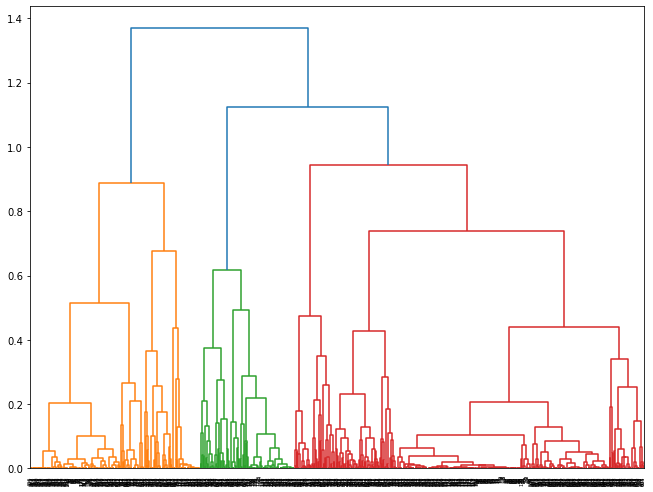

In [21]:
# Max (or complete linkage) algorithm with euclidian distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(X_2D, metric="minkowski", p=2) # Euclidian
ward_data = hac.complete(dist_mat) # max

hac.dendrogram(ward_data)#, labels=USArrests["State"].values);
plt.show()

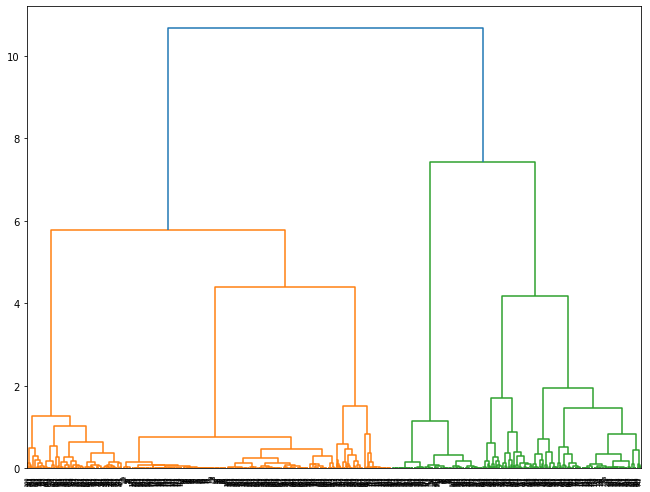

In [22]:
# Ward algorithm with euclidean distance
plt.figure(figsize=(11,8.5))
dist_mat = pdist(X_2D, metric="minkowski", p=2) # Euclidian
ward_data = hac.ward(dist_mat) # average

hac.dendrogram(ward_data)#, labels=USArrests["State"].values);
plt.show()

If sklearn can't draw dendogrames directly. It is nevertheless possible :

* to do agglomerative clustering with sklearn ([sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html))
* to draw dendograms with sklearn ([doc](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py))

In the following example, we search for 3 clusters using a Euclidean distance and ward as a linkage criterion.

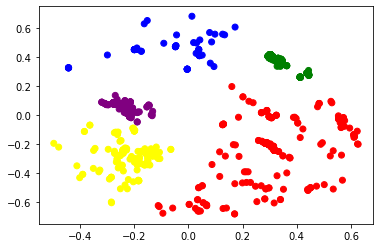

In [23]:
from sklearn.cluster import AgglomerativeClustering

struct_ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
struct_ac.fit_predict(X_2D)
color_labels = [colors[i] for i in struct_ac.labels_]
plt.scatter(X_2D[:,0], X_2D[:,1], c=color_labels)